In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import metrics
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [185]:
df=pd.read_csv("q_data_x.csv")

In [186]:
#使用する変数の設定
X=df[['T','F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',"child_dummy",'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin','marry_dummy', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'job_dummy8']]
y=df["cm_dummy"].values

In [187]:
X.head()

,T,F1,F2,F3,M1,M2,M3,TVwatch_day,child_dummy,area_kanto,area_keihan,area_tokai,area_keihanshin,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8
0,0,0,0,0,0,1,0,33.427600,1,0,0,0,1,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,31.542862,1,0,1,0,0,1,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,37.825805,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,36.345911,1,0,1,0,0,1,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,49.344942,1,0,1,0,0,1,1,0,0,0,0,0,0,0


In [188]:
#何も補正を入れない場合のATE（Average Treatment Effect）
print("CM接触者の平均プレイ時間",df[df["cm_dummy"]==1]["gamesecond"].mean())
print("CM非接触者の平均プレイ時間",df[df["cm_dummy"]==0]["gamesecond"].mean())

CM接触者の平均プレイ時間 2478.0658783783783
CM非接触者の平均プレイ時間 3107.7064549180327


# ロジスティック回帰

In [189]:
#ロジスティック回帰
from sklearn.linear_model import LogisticRegression
# ロジスティック回帰
lr = LogisticRegression()
lr.fit(X, y)
#傾向スコア
lr_pred=lr.predict_proba(X)[:,1]

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


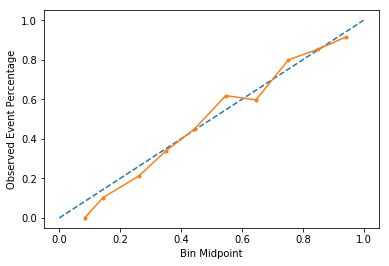

In [190]:
#calibrationplot
from sklearn.calibration import calibration_curve
gb_y, gb_x = calibration_curve(y, lr_pred, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(gb_x, gb_y, marker='.')
plt.xlabel("Bin Midpoint")
plt.ylabel("Observed Event Percentage")
plt.show()

In [191]:
# AUC
fpr, tpr, thresholds = metrics.roc_curve(y, lr_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.7841444342468933


In [192]:
#重み付け推定法
z1=df["cm_dummy"]
gy=df["gamesecond"]

ipwe1 = sum((z1*gy)/lr_pred)/sum(z1/lr_pred)
ipwe0 = sum(((1-z1)*gy)/(1-lr_pred))/sum((1-z1)/(1-lr_pred))
print(ipwe1)
print(ipwe0)
print(ipwe1 - ipwe0)

2991.2764857907982
2729.300702902091
261.9757828887073


# ランダムフォレスト

In [193]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
#rf = RandomForestClassifier(random_state=0)
#4foldでoofでやる
rf_pred=np.zeros((X.shape[0]))
rf_calibratedpred=np.zeros((X.shape[0]))
#sss = StratifiedShuffleSplit(n_splits=4,test_size=0.25,random_state=94)
sss = StratifiedKFold(n_splits=4, random_state=94, shuffle=True)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(i)
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_valid = y[train_index], y[test_index]
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0)
    rf.fit(X_train, y_train)
    rf_pred[test_index]=rf.predict_proba(X_valid)[:,1]
    
    #rf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0)
    rf_calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=5)
    rf_calibrated.fit(X_train, y_train)
    rf_calibratedpred[test_index] = rf_calibrated.predict_proba(X_valid)[:,1]

0
1
2
3


In [194]:
# AUC
fpr, tpr, thresholds = metrics.roc_curve(y, rf_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
fpr, tpr, thresholds = metrics.roc_curve(y, rf_calibratedpred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.8059838348484609
0.8150561390027324


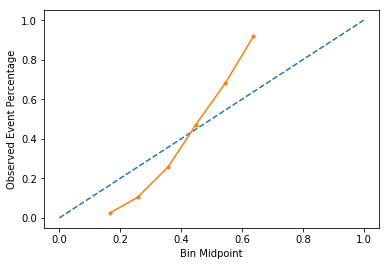

In [195]:
#calibrationplot
from sklearn.calibration import calibration_curve
gb_y, gb_x = calibration_curve(y, rf_pred, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(gb_x, gb_y, marker='.')
#gb_y, gb_x = calibration_curve(y, calibratedpred, n_bins=10)
#plt.plot(gb_x, gb_y, marker='.')
plt.xlabel("Bin Midpoint")
plt.ylabel("Observed Event Percentage")
plt.show()

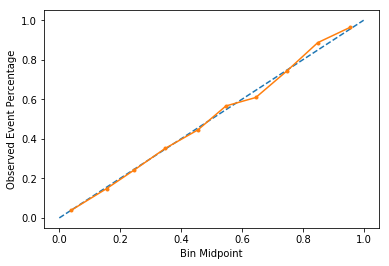

In [196]:
#calibrationplot
from sklearn.calibration import calibration_curve
#gb_y, gb_x = calibration_curve(y, rf_pred, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
#plt.plot(gb_x, gb_y, marker='.')
gb_y, gb_x = calibration_curve(y, rf_calibratedpred, n_bins=10)
plt.plot(gb_x, gb_y, marker='.')
plt.xlabel("Bin Midpoint")
plt.ylabel("Observed Event Percentage")
plt.show()

In [197]:
#重み付け推定法
#補正なし
z1=df["cm_dummy"]
gy=df["gamesecond"].values

ipwe1 = sum((z1*gy)/rf_pred)/sum(z1/rf_pred)
ipwe0 = sum(((1-z1)*gy)/(1-rf_pred))/sum((1-z1)/(1-rf_pred))
print(ipwe0)
print(ipwe1)
#ATE
print(ipwe1 - ipwe0)

#補正あり
ipwdf=pd.DataFrame()
ipwdf["pred"]=rf_calibratedpred
ipwdf["z1"]=df["cm_dummy"]
ipwdf["gy"]=df["gamesecond"].values
ipwdf=ipwdf[(ipwdf["pred"]>=0.01) &(ipwdf["pred"]<0.99) ]

rf_calibratedpred2=ipwdf["pred"].values
z1=ipwdf["z1"].values
gy=ipwdf["gy"].values

rf_calibratedpred=rf_calibratedpred
ipwe1 = sum((z1*gy)/rf_calibratedpred2)/sum(z1/rf_calibratedpred2)
ipwe0 = sum(((1-z1)*gy)/(1-rf_calibratedpred2))/sum((1-z1)/(1-rf_calibratedpred2))
print(ipwe0)
print(ipwe1)
#ATE
print(ipwe1 - ipwe0)

3040.188224698532
2759.2179125729012
-280.9703121256307
2858.3106112728797
3712.041675317884
853.7310640450041


# lightgbm

In [198]:
#lightgbm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
#4foldでoofでやる
lgb_pred=np.zeros((X.shape[0]))
lgb_calibratedpred=np.zeros((X.shape[0]))
#sss = StratifiedShuffleSplit(n_splits=4,test_size=0.25,random_state=94)
sss = StratifiedKFold(n_splits=4, random_state=94, shuffle=True)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_valid = y[train_index], y[test_index]
    
    #dtrain = lgb.Dataset(X_train, label=y_train)
    #dvalid = lgb.Dataset(X_valid, label=y_valid)
    #model = lgb.train(params, dtrain, num_boost_round=1000,valid_sets=[dtrain,dvalid],early_stopping_rounds=50,verbose_eval=100)
    model = lgb.LGBMClassifier(boosting_type= 'gbdt',objective = 'binary',)
    model.fit(X_train, y_train)
    lgb_pred[test_index]=model.predict_proba(X_valid)[:,1]
    #pd.Series(model.predict_proba(X_valid)[:,1]).hist(bins=30)
    
    #clf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0)
    lgb_calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=5)
    lgb_calibrated_model.fit(X_train, y_train)
    lgb_calibratedpred[test_index] = lgb_calibrated_model.predict_proba(X_valid)[:,1]

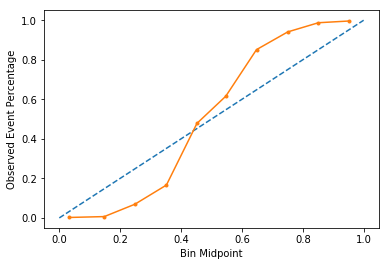

In [199]:
#calibrationplot
from sklearn.calibration import calibration_curve
gb_y, gb_x = calibration_curve(y, lgb_pred, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(gb_x, gb_y, marker='.')
#gb_y, gb_x = calibration_curve(y, calibratedpred, n_bins=10)
#plt.plot(gb_x, gb_y, marker='.')
plt.xlabel("Bin Midpoint")
plt.ylabel("Observed Event Percentage")
plt.show()

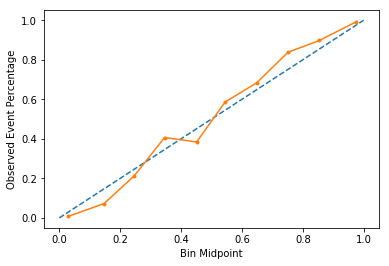

In [200]:
#calibrationplot
from sklearn.calibration import calibration_curve
#gb_y, gb_x = calibration_curve(y, pred, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
#plt.plot(gb_x, gb_y, marker='.')
gb_y, gb_x = calibration_curve(y, lgb_calibratedpred, n_bins=10)
plt.plot(gb_x, gb_y, marker='.')
plt.xlabel("Bin Midpoint")
plt.ylabel("Observed Event Percentage")
plt.show()

In [201]:
# AUC
fpr, tpr, thresholds = metrics.roc_curve(y, lgb_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
fpr, tpr, thresholds = metrics.roc_curve(y, lgb_calibratedpred)
auc = metrics.auc(fpr, tpr)
print(auc)

0.9667850483680402
0.9708886424114397


In [202]:
#重み付け推定法
#補正前
z1=df["cm_dummy"]
gy=df["gamesecond"].values

ipwe1 = sum((z1*gy)/lgb_pred)/sum(z1/lgb_pred)
ipwe0 = sum(((1-z1)*gy)/(1-lgb_pred))/sum((1-z1)/(1-lgb_pred))
print(ipwe0)
print(ipwe1)
#ATE
print(ipwe1 - ipwe0)

#補正後
ipwdf=pd.DataFrame()
ipwdf["pred"]=lgb_calibratedpred
ipwdf["z1"]=df["cm_dummy"]
ipwdf["gy"]=df["gamesecond"].values
ipwdf=ipwdf[(ipwdf["pred"]>=0.01) &(ipwdf["pred"]<0.99) ]

lgb_calibratedpred2=ipwdf["pred"].values
z1=ipwdf["z1"].values
gy=ipwdf["gy"].values

ipwe1 = sum((z1*gy)/lgb_calibratedpred2)/sum(z1/lgb_calibratedpred2)
ipwe0 = sum(((1-z1)*gy)/(1-lgb_calibratedpred2))/sum((1-z1)/(1-lgb_calibratedpred2))
print(ipwe0)
print(ipwe1)
#ATE
print(ipwe1 - ipwe0)

2854.1857886312214
3464.353163513029
610.1673748818075
2689.0126197323625
5129.54679490276
2440.5341751703972


In [203]:
#重み付け推定法(傾向スコア0.1以上)
ipwdf=pd.DataFrame()
ipwdf["pred"]=lgb_calibratedpred
ipwdf["z1"]=df["cm_dummy"]
ipwdf["gy"]=df["gamesecond"].values
ipwdf=ipwdf[(ipwdf["pred"]>=0.1)&(ipwdf["pred"]<0.99) ]

lgb_calibratedpred2=ipwdf["pred"].values
z1=ipwdf["z1"].values
gy=ipwdf["gy"].values

#ATE
#calibratedpred2=np.clip(calibratedpred2,0.01,0.99) #計算の都合上clip
ipwe1 = sum((z1*gy)/lgb_calibratedpred2)/sum(z1/lgb_calibratedpred2)
ipwe0 = sum(((1-z1)*gy)/(1-lgb_calibratedpred2))/sum((1-z1)/(1-lgb_calibratedpred2))
print(ipwe0)
print(ipwe1)
#ATE
print(ipwe1 - ipwe0)

1711.622811531692
2979.062748562858
1267.439937031166


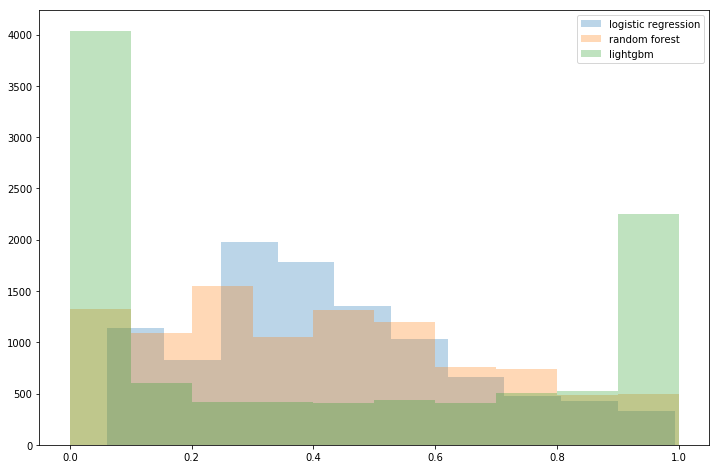

In [204]:
plt.figure(figsize=(12,8))
plt.hist(lr_pred,alpha=0.3,label="logistic regression")
plt.hist(rf_calibratedpred,alpha=0.3,label="random forest")
plt.hist(lgb_calibratedpred,alpha=0.3,label="lightgbm")
plt.legend()
plt.show()

In [183]:
#層別マッチング(確認用)
#層別マッチング(0.05刻み)
interval = np.arange(0,1.05,0.05)
match_list = []
table=df[["cm_dummy","gamesecond"]]
table["ps"]=lgb_calibratedpred
for i in range(0,len(interval)-1):
    temp0 = table[(table['cm_dummy']==0) & (interval[i] < table['ps']) & (table['ps'] < interval[i+1])]
    temp1 = table[(table['cm_dummy']==1) & (interval[i] < table['ps']) & (table['ps'] < interval[i+1])]
    if (len(temp0) > 0) & (len(temp1) > 0):
        match_list.append(temp1['gamesecond'].mean()-temp0['gamesecond'].mean())
        print(i)
        print(len(temp1),len(temp0),len(temp1)/len(temp0))
        print(temp1['gamesecond'].mean())
        print(temp0['gamesecond'].mean())

np.mean(match_list)

0
12 3130 0.0038338658146964857
18383.083333333332
3077.2373801916933
1
18 572 0.03146853146853147
46783.0
6437.0944055944055
2
19 305 0.06229508196721312
18935.21052631579
3429.085245901639
3
25 256 0.09765625
4078.72
3173.953125
4
53 176 0.30113636363636365
0.0
2159.278409090909
5
36 152 0.23684210526315788
1682.138888888889
1115.8815789473683
6
94 146 0.6438356164383562
0.0
3310.054794520548
7
74 99 0.7474747474747475
4419.472972972973
0.0
8
66 127 0.5196850393700787
5787.348484848485
5062.535433070866
9
90 123 0.7317073170731707
3426.5777777777776
1890.0731707317073
10
114 125 0.912
2462.1754385964914
2913.104
11
140 54 2.5925925925925926
1184.0428571428572
81.70370370370371
12
131 86 1.5232558139534884
14869.900763358779
431.25581395348837
13
147 43 3.4186046511627906
5446.571428571428
70.51162790697674
14
206 38 5.421052631578948
4628.97572815534
79.8157894736842
15
214 43 4.976744186046512
2943.873831775701
792.0232558139535
16
188 30 6.266666666666667
1034.4468085106382
2270.3


/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


5048.117439082355